In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras import layers
import numpy as np
from PIL import Image


class VAE(Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.latent_dim = latent_dim

        self.encoder = Sequential(
            [
                layers.Input(shape=(32, 32, 1)),
                layers.Conv2D(32, 3, activation="relu", padding="same", strides=2),
                layers.Conv2D(64, 3, activation="relu", padding="same", strides=2),
                layers.Flatten(),
                layers.Dense(latent_dim * 2),
            ],
            name="Encoder",
        )

        self.decoder = Sequential(
            [
                layers.Input(shape=(latent_dim,)),
                layers.Dense(8 * 8 * 128, activation="relu"),
                layers.Reshape((8, 8, 128)),
                layers.Conv2DTranspose(
                    64, 3, activation="relu", padding="same", strides=2
                ),
                layers.Conv2DTranspose(
                    32, 3, activation="relu", padding="same", strides=2
                ),
                layers.Conv2DTranspose(
                    1, 3, activation="sigmoid", padding="same", strides=1
                ),
            ],
            name="Decoder",
        )
        self.optimizer = keras.optimizers.Adam()

    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sample_z(z_mean=z_mean, z_log_var=z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def sample_z(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def compute_loss(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sample_z(z_mean=z_mean, z_log_var=z_log_var)
        reconstructed = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        return reconstruction_loss + 0.001 * kl_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": loss}

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({"latent_dim": self.latent_dim})
        return config

    @classmethod
    def from_config(cls, config):
        latent_dim = config.pop("latent_dim")
        return cls(latent_dim, **config)

2024-09-15 20:12:20.042267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 20:12:20.053792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 20:12:20.057235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 20:12:20.068173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 20:12:20.688869: W tensorflow/compiler/tf2

In [6]:
model = VAE(2)

images = []
for i in range(10):
    img = Image.open(f"{i}.png").convert("L")
    img = np.array(img).astype(np.float32) / 255.0
    images.append(img)

x_train = np.array(images)
x_train = np.expand_dims(x_train, axis=-1)

In [17]:
model.compile(optimizer=keras.optimizers.Adam())

model.fit(x_train, x_train, epochs=500)

model.save("model.keras")

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1165
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1157
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1148
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1137
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1127
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1123
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1099
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1065
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1038
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1007
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0969
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0951
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0793
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0728
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0608
Epoch 16/500
1/1 ━━━━

/home/smiilliin/.local/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [23]:
model = keras.models.load_model("model.keras", custom_objects={"VAE": VAE})

/home/smiilliin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


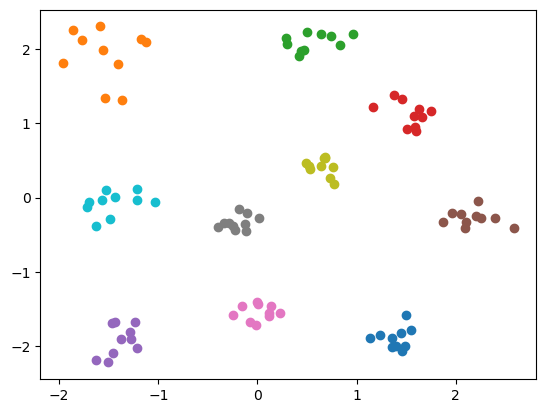

In [24]:
from matplotlib import pyplot as plt

z_mean, z_log_var = tf.split(
    model.encoder.predict(x_train), num_or_size_splits=2, axis=1
)

zx = [[] for _ in range(10)]
zy = [[] for _ in range(10)]

for _ in range(10):
    z_result = model.sample_z(z_mean=z_mean, z_log_var=z_log_var)

    for i, z in enumerate(z_result):
        zx[i].append(float(z[0]))
        zy[i].append(float(z[1]))

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

for i, (x, y) in enumerate(zip(zx, zy)):
    plt.plot(x, y, "o", color=colors[i])
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


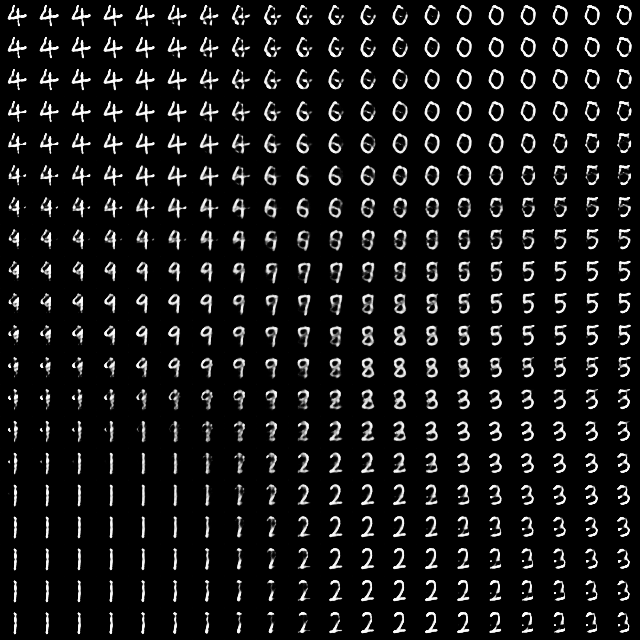

In [25]:
n = 20
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)
x, y = np.meshgrid(grid_x, grid_y)
x = x.ravel()
y = y.ravel()

z = np.array(list(zip(x, y)))
constructed = model.decoder.predict(z)

image = np.zeros((n * 32, n * 32)).astype(np.uint8)

for i, img in enumerate(constructed):
    img = (img * 255).reshape(32, 32).astype(np.uint8)
    x = i % n
    y = i // n

    image[y * 32 : (y + 1) * 32, x * 32 : (x + 1) * 32] = img

image = Image.fromarray(image)
display(image)

In [78]:
import tensorflow as tf

z_mean, _ = tf.split(model.encoder.predict(x_train), num_or_size_splits=2, axis=1)
z_mean = np.array(z_mean)

n = 30

x = []
y = []
for i in range(9):
    x.append(np.linspace(z_mean[i][0], z_mean[i + 1][0], n))
    y.append(np.linspace(z_mean[i][1], z_mean[i + 1][1], n))

x = np.array(x).flatten()
y = np.array(y).flatten()

z = np.array(list(zip(x, y)))
constructed = model.decoder.predict(z)
constructed = (constructed * 255).reshape(-1, 32, 32).astype(np.uint8)

images = [Image.fromarray(image) for image in constructed]

img = Image.new("RGBA", (32, 32), (0, 0, 0))
img.save("out.gif", save_all=True, append_images=images, duration=(1000 // n), loop=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [55]:
model.summary()

Model: "vae_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder (Sequential)            │ (None, 4)              │       100,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,141 (1.32 MB)

 Trainable params: 347,141 (1.32 MB)

 Non-trainable params: 0 (0.00 B)